In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn import neighbors
import time
import torch.utils.data as data
from glob import glob
import zstandard as zstd
import msgpack
import msgpack_numpy
import os
import dataflow
import numpy as np
from collections import namedtuple


In [2]:
train_files = sorted(glob(os.path.join('../lagrangian_simulation/DeepLagrangianFluids/datasets/ours_default_data', 'train', '*.zst')))

In [3]:
class PhysicsSimDataFlow(dataflow.RNGDataFlow):
    """Data flow for msgpacks generated from SplishSplash simulations.
    """

    def __init__(self, files, window=5):
        if not len(files):
            raise Exception("List of files must not be empty")
        if window < 1:
            raise Exception("window must be >=1 but is {}".format(window))
        self.files = files
        self.window = window

    def __iter__(self):
        decompressor = zstd.ZstdDecompressor()
        files_idxs = np.arange(len(self.files))

        for file_i in files_idxs:
            # read all data from file
            with open(self.files[file_i], 'rb') as f:
                data = msgpack.unpackb(decompressor.decompress(f.read()),
                                       raw=False)

            label_delta_frame = 1
            data_idxs = np.arange(self.window - 1, len(data) - label_delta_frame)

            # get box from first item. The box is valid for the whole file
            box = data[0]['box']
            box_normals = data[0]['box_normals']

            for data_i in data_idxs:

                sample = {'box': box, 'box_normals': box_normals}

                # Get last frames (for features)
                for time_i in range(self.window):

                    item = data[data_i - time_i]

                    for k in ('pos', 'vel'):
                        sample[k + str(time_i)] = item[k]

                    for k in ('m', 'viscosity', 'frame_id', 'scene_id'):
                        sample[k + str(time_i)] = item[k]
                
                # Get next frame (for label)

                item = data[data_i + label_delta_frame]

                for k in ('pos', 'vel'):
                    sample[k + 'next' + str(label_delta_frame)] = item[k]

                for k in ('m', 'viscosity', 'frame_id', 'scene_id'):
                    sample[k + 'next' + str(label_delta_frame)] = item[k]

                yield sample

In [4]:
_k = 1000
TrainParams = namedtuple('TrainParams', ['max_iter', 'base_lr', 'batch_size'])
train_params = TrainParams(50 * _k, 0.001, 16)

df = PhysicsSimDataFlow(train_files, window=5)
df = dataflow.BatchData(df, batch_size=train_params.batch_size, use_list=True)
df.reset_state()

data_iter = iter(df)

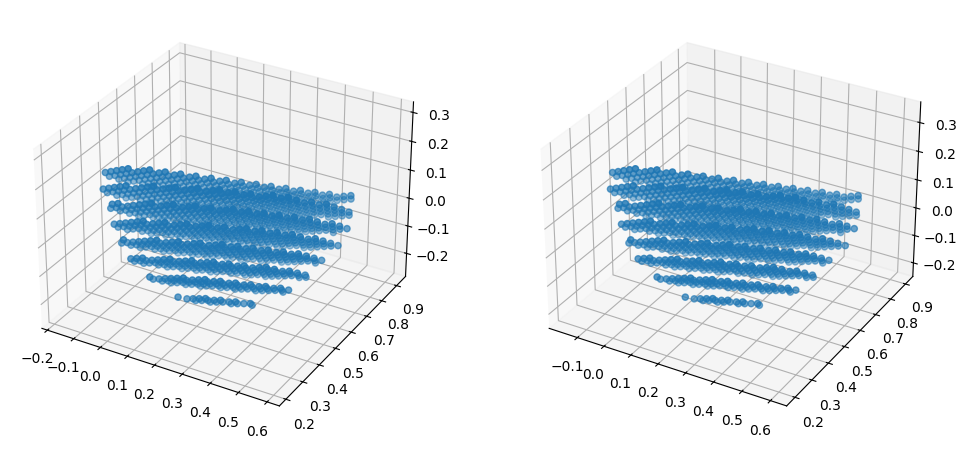

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))
plot_data= next(data_iter).copy()
this_frame = plot_data['pos0'][0]
next_frame = plot_data['posnext1'][0]
num_points = 1000

# Frame i
axs[0].scatter(this_frame[:num_points, 0], this_frame[:num_points, 1], this_frame[:num_points, 2], marker='o')

# Frame i+1
axs[1].scatter(next_frame[:num_points, 0], next_frame[:num_points, 1], next_frame[:num_points, 2], marker='o')

plt.show()


In [8]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, mlp_hidden_size, mlp_num_hidden_layers, output_size):
        super().__init__()

        self.input_size = input_size
        self._mlp_hidden_size = mlp_hidden_size
        self._mlp_num_hidden_layers = mlp_num_hidden_layers
        self._output_size = output_size

        self.first_layer = nn.Linear(input_size, mlp_hidden_size)

        self.hidden_layers = []
        for _ in range(self._mlp_num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(self._mlp_hidden_size, self._mlp_hidden_size))

        self.last_layer = nn.Linear(self._mlp_hidden_size, self._output_size)
    

    def forward(self, x):
        x = F.relu(self.first_layer(x))

        for layer in range(self._mlp_num_hidden_layers - 1):
            x = F.relu(self.hidden_layers[layer](x))

        x = F.relu(self.last_layer(x))

        return x


class EncodeProcessDecode(nn.Module):
    def __init__(self, input_size, latent_size, mlp_hidden_size, mlp_num_hidden_layers, num_message_passing_steps, output_size):
        super().__init__()

        self._input_size = input_size
        self._latent_size = latent_size
        self._mlp_hidden_size = mlp_hidden_size
        self._mlp_num_hidden_layers = mlp_num_hidden_layers
        self._num_message_passing_steps = num_message_passing_steps
        self._output_size = output_size

        self.build_networks()


    def forward(self, input_graph):

        # Encode the input_graph.
        latent_graph_0 = self._encode(input_graph)

        # Do `m` message passing steps in the latent graphs.
        latent_graph_m = self._process(latent_graph_0)

        # Decode from the last latent graph.
        return self._decode(latent_graph_m)


    def _encode(self, input_graph):
        """Encodes the input point cloud represented as a graph into a graph with latent features"""
        x = input_graph.x.float()
        x = self._encoder_network(x)

        return Data(x=x, edge_index=input_graph.edge_index)


    def _process(self, latent_graph_0):
        """Does `m` steps of message passing in each graph"""

        # For now just forwards the edges without computing anything with them
        
        latent_graph_prev_k = latent_graph_0.x.float()
        latent_graph_k = latent_graph_0.x.float()
        
        for step in range(self._num_message_passing_steps):
            latent_graph_k = self._processor_networks[step](latent_graph_prev_k)
            latent_graph_prev_k = latent_graph_k

        latent_graph_m = latent_graph_k

        return Data(x=latent_graph_m, edge_index=latent_graph_0.edge_index)


    def _decode(self, latent_graph_m):
        """Decodes the `m`-th latent graph back into a graph with output features equal to input"""
        return Data(x=self._decoder_network(latent_graph_m.x.float()), edge_index=latent_graph_m.edge_index)


    def build_networks(self):
        self._encoder_network = self.build_mlp(input_size=self._input_size, 
                                               hidden_size=self._mlp_hidden_size, 
                                               num_hidden_layers=self._mlp_num_hidden_layers, 
                                               output_size=self._latent_size)

        self._processor_networks = []
        for _ in range(self._num_message_passing_steps):
            self._processor_networks.append(
                self.build_mlp(input_size=self._latent_size, 
                               hidden_size=self._mlp_hidden_size, 
                               num_hidden_layers=self._mlp_num_hidden_layers, 
                               output_size=self._latent_size)
            )

        self._decoder_network = self.build_mlp(input_size=self._latent_size, 
                                               hidden_size=self._mlp_hidden_size, 
                                               num_hidden_layers=self._mlp_num_hidden_layers, 
                                               output_size=self._output_size)


    def build_mlp(self, input_size: int, hidden_size: int, num_hidden_layers: int, output_size: int) -> nn.Module:
        return SimpleMLP(input_size, hidden_size, num_hidden_layers, output_size)

In [17]:
class LearnedSimulator(nn.Module):
    def __init__(
            self,
            num_dimensions,
            connectivity_radius,
            input_size = 15,
            latent_size = 30,
            mlp_hidden_size = 100,
            mlp_num_hidden_layers = 1,
            num_message_passing_steps = 8,
            output_size = 3):
        super().__init__()


        self_num_dimensions = num_dimensions
        # This parameter sets the kernel radius (SPH inspired)
        self._connectivity_radius = connectivity_radius

        # This network takes care of learnable message passing in the graphs
        self._graph_network = EncodeProcessDecode(input_size=input_size,
                                                  latent_size=latent_size,
                                                  mlp_hidden_size=mlp_hidden_size,
                                                  mlp_num_hidden_layers=mlp_num_hidden_layers,
                                                  num_message_passing_steps=num_message_passing_steps,
                                                  output_size=output_size)


    def forward(self, positions, velocities):

        graph_0 = self._encoder_preprocessor(positions, velocities, self._connectivity_radius)

        graph_m = self._graph_network(graph_0)
        
        return self._decoder_postprocessor(graph_m)
            

    def _encoder_preprocessor(self, positions, velocities, radius):
        node_features_list = []
        edge_index_list = [] 

        (senders, receivers) = self._compute_connectivity(positions, radius)

        num_points_per_graph = len(positions)

        # This array will store concatenated velocities for each node in the current graph
        graph_node_features = np.zeros((num_points_per_graph, 0))

        # Iterate over each frame
        for vel in velocities:
            graph_node_features = np.concatenate((graph_node_features, vel), axis=1)

        node_features_list.append(graph_node_features)
        edge_index_list.append((senders, receivers))

        node_features = np.array(node_features_list)
        node_features = torch.tensor(node_features)
        edge_index_tensors = [torch.tensor(indices) for indices in edge_index_list]

        graph_node_features = torch.tensor(graph_node_features)
        edge_index_tensors = torch.tensor((senders, receivers))
        data = Data(
            x=graph_node_features,  # Features for the current graph
            edge_index=edge_index_tensors,  # Edge indices for the current graph
            # edge_attr=torch.cat(edge_features, dim=-1),
            # num_nodes=n_node,
            # num_edges=n_edge,
            # globals=global_context
        )

        return data
    

    def _decoder_postprocessor(self, input_final_graph):
        return input_final_graph.x
    

    def _compute_connectivity(self, positions, radius, add_self_edges=True):
        """Get the indices of connected edges with radius connectivity.

        Args:
            positions: Positions of nodes in the graph. Shape:
            [num_nodes_in_graph, num_dims].
            radius: Radius of connectivity.
            add_self_edges: Whether to include self edges or not.

        Returns:
            senders indices [num_edges_in_graph]
            receiver indices [num_edges_in_graph]

        """
        tree = neighbors.KDTree(positions)
        receivers_list = tree.query_radius(positions, r=radius)
        num_nodes = len(positions)
        senders = np.repeat(range(num_nodes), [len(a) for a in receivers_list])
        receivers = np.concatenate(receivers_list, axis=0)

        if not add_self_edges:
            # Remove self edges.
            mask = senders != receivers
            senders = senders[mask]
            receivers = receivers[mask]

        return senders, receivers



In [18]:
model = LearnedSimulator(num_dimensions=3, connectivity_radius=0.1)
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=train_params.base_lr,
                                 eps=1e-6)
loss_module = nn.MSELoss()

In [29]:
def train(model, batch):
    model.train()
    optimizer.zero_grad()
    losses = []
    batch_size = train_params.batch_size

    for batch_i in range(batch_size):
        input_positions = batch['pos0'][batch_i]
        input_velocities = [batch[f'vel{i}'][batch_i] for i in range(5)]

        next_positions_labels = torch.Tensor(batch['posnext1'][batch_i])
        preds = model(input_positions, input_velocities)
        loss = loss_module(preds, next_positions_labels)

        losses.append(loss)

    total_loss = sum(losses) / batch_size
    total_loss.backward()
    optimizer.step()

    return total_loss

In [30]:
train_count = 0

while train_count < train_params.max_iter:
    data_fetch_start = time.time()
    batch = next(data_iter)

    current_loss = train(model, batch)

    display_str_list = ['loss', float(current_loss)]
    train_count += 1

    if train_count % 10 == 0:
        print(train_count, 'current loss is: ', current_loss)